# Sampling from a uniform distribution over a polytope
We consider a vector of variables $x \in \mathbb{R}^n$ subject to systems of linear inequality constraints, $\mathbf{A_1} x \leq b_1$.
These constraints form the faces of a convex polytope in $\mathbb{R}^n$, and the solutions satisfying the constraints fall inside this polytope.
Additionally we might have a system of equality constraints, $\mathbf{A_2} x = b_2$, effectively reducing the dimensionality of the space in which the solution lie.

For several applications we want to sample uniformly under these constraints.
For example a mixture can be described as $x \in [0, 1]^n$ with $\sum x_i = 1$, i.e. a unit-simplex. 
Sampling uniformly from this simplex can be done, e.g. using the exponential distribution (and normalizing to 1) or using the Dirichlet distribution.
However, this is not possible anymore, when the individiual mixture components are individually bounded $x_{i,min} \leq x_i \leq x_{i,max}$.

For a general solution to this problem we need to employ Markov Chain Monte Carlo sampling methods.
A review of such sampling methods for the specific case of convex polytopes is given in https://arxiv.org/abs/1710.08165.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import diversipy

## Sampling under equality constraints

Equality constraints $Ax = b$ reduce the dimensionality of the polytope.
Solutions can be found via the nullspace of A, i.e. the subspace containing the homogeneous solutions of $Ax = 0$, and adding a particular solution of $Ax = b$.

In [2]:
# Example: x1 + x2 + x3 = 1
A = np.array([[1, 1, 1]])
b = np.array([1])

N, xp = diversipy.polytope.solve_equality(A, b)
print(f"nullspace:\n{N}")
print(f"particular solution: {xp}")

nullspace:
[[-0.57735027 -0.57735027]
 [ 0.78867513 -0.21132487]
 [-0.21132487  0.78867513]]
particular solution: [0.33333333 0.33333333 0.33333333]


The nullspace basis and particular solution can be used to project to the subspace $z \in \mathbb{R}^m$ and back.  
Note that $z = N \cdot (x - x_p) = N \cdot x - N \cdot x_p = N \cdot x$ so we don't need to substract the particular solution when projecting to the subspace.

In [3]:
X1 = np.array([
    [1, 0, 0],
    [0, 9, -8],
    [2, -1, 0],
    [0.1, 0.4, 0.5]
])
X1.round(3)

array([[ 1. ,  0. ,  0. ],
       [ 0. ,  9. , -8. ],
       [ 2. , -1. ,  0. ],
       [ 0.1,  0.4,  0.5]])

In [4]:
Z = X1 @ N
X2 = Z @ N.T + xp
X2.round(3)

array([[ 1. ,  0. ,  0. ],
       [-0. ,  9. , -8. ],
       [ 2. , -1. ,  0. ],
       [ 0.1,  0.4,  0.5]])

We can sample solutions in the unbounded projected space.

In [5]:
Z = np.random.uniform(low=-1, high=1, size=(5, 2)) 
X = Z @ N.T + xp
print(f"some random solutions:\n{X}")
print("do they satisfy Ax=b?", np.allclose(X @ A.T, b))

some random solutions:
[[ 0.08467589  0.11441739  0.80090672]
 [ 0.38901666 -0.58817925  1.19916259]
 [ 0.42649104 -0.45568571  1.02919467]
 [ 0.41255803  0.68093568 -0.0934937 ]
 [-0.58205599  0.89382612  0.68822986]]
do they satisfy Ax=b? True


The projection to the nullspace and back can be used to make any point satisfy $Ax = b$.-

In [6]:
X1 = np.array([
    [1, 2, 2],
    [1, 0, 0],
    [0, 9, 9]
])

Z = X1 @ N
X2 = Z @ N.T + xp

print(f"X1 (all valid? {np.allclose(X1 @ A.T, b)}):\n{X1}")
print(f"X2 (all valid? {np.allclose(X2 @ A.T, b)}):\n{X2.round(2)}")

X1 (all valid? False):
[[1 2 2]
 [1 0 0]
 [0 9 9]]
X2 (all valid? True):
[[-0.33  0.67  0.67]
 [ 1.    0.    0.  ]
 [-5.67  3.33  3.33]]


## Sampling under inequality constraints

Let's consider the example of sampling $x \in \mathbb{R}^2$ subject to
\begin{align}
0.1 \leq x_1 &\leq 0.9 \\
0.2 \leq x_2 &\leq 1 \\
1/2 x_1 + x_2 &\leq 1 \\
0.2 \leq -2/3 x_1 + x_2
\end{align}

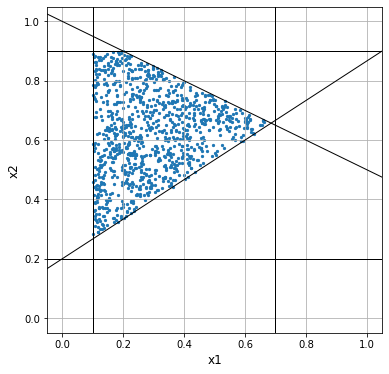

In [10]:
# bounds
lower = [0.1, 0.2]
upper = [0.7, 0.9]

# inequality constraints
A1 = np.array([[1 / 2, 1], [2 / 3, -1]])
b1 = np.array([1, -0.2])

points = diversipy.polytope.sample(n_points=1000, lower=lower, upper=upper, A1=A1, b1=b1)

fig, ax = plt.subplots(figsize=(6, 6))
x1lim = np.array([-0.05, 1.05])
x2lim = np.array([-0.05, 1.05])
ax.scatter(*points.T, s=5)
for ai, bi in zip(A1, b1):
    x1 = x1lim
    x2 = (bi - x1 * ai[0]) / ai[1]  # a1 x1 + a2 x2 = b --> x2 = (b - a1 x1) / a2
    ax.plot(x1, x2, 'k', lw=1)

ax.axvline(lower[0], color='k', lw=1)
ax.axhline(lower[1], color='k', lw=1)
ax.axvline(upper[0], color='k', lw=1)
ax.axhline(upper[1], color='k', lw=1)

ax.grid()
ax.set(xlim=x1lim, ylim=x2lim, xlabel="x1", ylabel="x2");
fig.savefig("polytope.png")

## Sampling under both equality and inequality constraints

As example we consider sampling from the unit-simplex in R³.

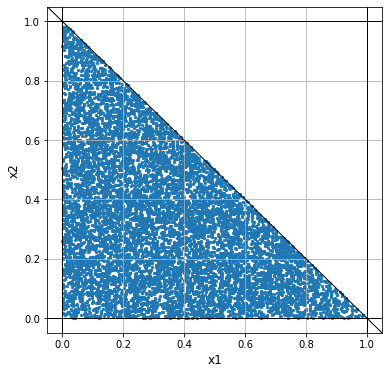

In [8]:
# bounds
lower = [0, 0, 0]
upper = [1, 1, 1]

# equality constraints
A2 = np.array([[1, 1, 1]])
b2 = np.array([1])

X = diversipy.polytope.sample(n_points=10000, lower=lower, upper=upper, A2=A2, b2=b2)

fig, ax = plt.subplots(figsize=(6, 6))
x1lim = np.array([-0.05, 1.05])
x2lim = np.array([-0.05, 1.05])
ax.scatter(X[:, 0], X[:, 1], s=5)
for ai, bi in zip(A2, b2):
    x1 = x1lim
    x2 = (bi - x1 * ai[0]) / ai[1]  # a1 x1 + a2 x2 = b --> x2 = (b - a1 x1) / a2
    ax.plot(x1, x2, 'k', lw=1)

ax.axvline(lower[0], color='k', lw=1)
ax.axhline(lower[1], color='k', lw=1)
ax.axvline(upper[0], color='k', lw=1)
ax.axhline(upper[1], color='k', lw=1)

ax.grid()
ax.set(xlim=x1lim, ylim=x2lim, xlabel="x1", ylabel="x2");

We can compare with `simplex.sample` function which is specific to the unit-simplex and see agreement.

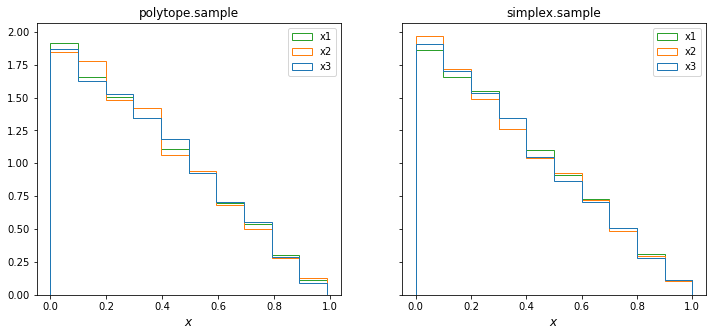

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5), sharey=True)
ax1.hist(X, histtype="step", density=True)

Xs = diversipy.simplex.sample(dimension=3, n_points=10000)
ax2.hist(Xs, histtype="step", bins=np.linspace(0, 1, 11), density=True)

for ax in (ax1, ax2):
    ax.legend([f"x{i+1}" for i in range(3)])
    ax.set(xlabel="$x$")

ax1.set(title="polytope.sample")
ax2.set(title="simplex.sample");